<a href="https://colab.research.google.com/github/jithurjacob/Recommendation-Engine-Algorithms/blob/master/ImageEmbeddingProjector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://medium.com/@kumon/visualizing-image-feature-vectors-through-tensorboard-b850ce1be7f1

In [22]:
! git clone https://github.com/jasjotiitr/Capillary-Machine-Learning-Hackathon.git

fatal: destination path 'Capillary-Machine-Learning-Hackathon' already exists and is not an empty directory.


In [23]:
!ls Capillary-Machine-Learning-Hackathon/train-\ Capillary\ 4/images | head -n 10

11139192.jpg
11139194.jpg
11139524.jpg
11139560.jpg
11139588.jpg
11139650.jpg
11141306.jpg
11141308.jpg
11141318.jpg
11141320.jpg


In [24]:
!sudo apt install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.4).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [25]:
!cat  /etc/ImageMagick-6/policy.xml


<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE policymap [
<!ELEMENT policymap (policy)+>
<!ELEMENT policy (#PCDATA)>
<!ATTLIST policy domain (delegate|coder|filter|path|resource) #IMPLIED>
<!ATTLIST policy name CDATA #IMPLIED>
<!ATTLIST policy rights CDATA #IMPLIED>
<!ATTLIST policy pattern CDATA #IMPLIED>
<!ATTLIST policy value CDATA #IMPLIED>
]>
 <!-- <policy domain="resource" name="temporary-path" value="/tmp"/> -->
  <!-- <policy domain="resource" name="memory" value="2GiB"/> -->
  <!-- <policy domain="resource" name="map" value="4GiB"/> -->
  <!-- <policy domain="resource" name="area" value="1GB"/> -->
  <!-- <policy domain="resource" name="disk" value="16EB"/> -->
  <!-- <policy domain="resource" name="file" value="768"/> -->
  <!-- <policy domain="resource" name="thread" value="4"/> -->
  <!-- <policy domain="resource" name="throttle" value="0"/> -->
  <!-- <policy domain="resource" name="time" value="3600"/> -->
  <!-- <policy domain="system" name="precision" value="6"/> --

In [0]:
p = """
<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE policymap [
<!ELEMENT policymap (policy)+>
<!ELEMENT policy (#PCDATA)>
<!ATTLIST policy domain (delegate|coder|filter|path|resource) #IMPLIED>
<!ATTLIST policy name CDATA #IMPLIED>
<!ATTLIST policy rights CDATA #IMPLIED>
<!ATTLIST policy pattern CDATA #IMPLIED>
<!ATTLIST policy value CDATA #IMPLIED>
]>
 <!-- <policy domain="resource" name="temporary-path" value="/tmp"/> -->
  <!-- <policy domain="resource" name="memory" value="2GiB"/> -->
  <!-- <policy domain="resource" name="map" value="4GiB"/> -->
  <!-- <policy domain="resource" name="area" value="1GB"/> -->
  <!-- <policy domain="resource" name="disk" value="16EB"/> -->
  <!-- <policy domain="resource" name="file" value="768"/> -->
  <!-- <policy domain="resource" name="thread" value="4"/> -->
  <!-- <policy domain="resource" name="throttle" value="0"/> -->
  <!-- <policy domain="resource" name="time" value="3600"/> -->
  <!-- <policy domain="system" name="precision" value="6"/> -->
  <policy domain="cache" name="shared-secret" value="passphrase"/>
  <policy domain="coder" rights="none" pattern="EPHEMERAL" />
  <policy domain="coder" rights="none" pattern="URL" />
  <policy domain="coder" rights="none" pattern="HTTPS" />
  <policy domain="coder" rights="none" pattern="MVG" />
  <policy domain="coder" rights="none" pattern="MSL" />
  <policy domain="coder" rights="none" pattern="TEXT" />
  <policy domain="coder" rights="none" pattern="SHOW" />
  <policy domain="coder" rights="none" pattern="WIN" />
  <policy domain="coder" rights="none" pattern="PLT" />
  <policy domain="path" rights="none" pattern="@*" />
</policymap>
"""

c = """text_file = open("/etc/ImageMagick-6/policy.xml", "w");text_file.write(p);text_file.close()""" 

exec(c)

In [0]:
!montage Capillary-Machine-Learning-Hackathon/train-\ Capillary\ 4/images/*.jpg  -geometry 50x50! sprite.jpg

In [28]:
!ls

Capillary-Machine-Learning-Hackathon  projector_config.pbtxt  sprite.jpg
feature_vecs_inception.tsv	      sample_data


In [0]:
# from google.colab import files
# files.download('sprite.jpg') 
# files.download('sprite-0.jpg')
# files.download('sprite-1.jpg') 

In [0]:
# Extract vectors

In [0]:
import csv
import glob
import tensorflow as tf
import tensorflow_hub as hub

module = hub.Module("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1")
height, width = hub.get_expected_image_size(module)
ch = 3
batch_size = 10


In [0]:
# image_list = tf.convert_to_tensor(['Capillary-Machine-Learning-Hackathon/train- Capillary 4/images/*.jpg'.format(i+1) for i in range(302)])


In [0]:
import glob
images = glob.glob("Capillary-Machine-Learning-Hackathon/train- Capillary 4/images/*.jpg")

In [39]:
!tf.VERSION

/bin/bash: tf.VERSION: command not found


In [0]:

import glob
image_list = tf.convert_to_tensor(glob.glob("Capillary-Machine-Learning-Hackathon/train- Capillary 4/images/*.jpg"))

In [34]:


input_queue = tf.train.slice_input_producer([image_list], num_epochs=1, shuffle=False)

image_bytes = tf.read_file(input_queue[0])
image = tf.image.decode_image(image_bytes, channels=ch)
image = tf.image.resize_bilinear([image], [height, width])
image = tf.reshape(image, tf.stack([height, width, ch]))
images = tf.train.batch([image], batch_size=batch_size, allow_smaller_final_batch=True)
features = module(images)

with open('feature_vecs_inception.tsv', 'w') as fw:
    csv_writer = csv.writer(fw, delimiter='\t')
    with tf.Session() as sess:
        sess.run([tf.local_variables_initializer(),
                  tf.global_variables_initializer()])
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        try:
            while not coord.should_stop():
                fvecs = sess.run(features)
                csv_writer.writerows(fvecs)
        except:
            pass
        finally:
            coord.request_stop()
            coord.join(threads)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0409 11:45:00.567646 140540513077120 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [35]:
!ls

Capillary-Machine-Learning-Hackathon  projector_config.pbtxt  sprite.jpg
feature_vecs_inception.tsv	      sample_data


In [0]:
# try neighbours

In [0]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import random

In [0]:
fvecs = df = pd.read_csv("feature_vecs_inception.tsv", sep="\t", header=None)

In [48]:
fvecs.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1.803693,5.351174,0.285035,232.64406,13.050706,55.127270,0.703600,141.456120,80.782760,36.714560,...,37.664368,4.895418,52.756805,0.583612,17.848562,7.268144,238.93231,5.601057,2.321046,0.066718
1,1.636647,0.147171,4.016878,221.50107,21.642721,46.674614,0.851647,87.114740,36.987988,44.035446,...,2.014929,27.046303,0.534473,2.396825,2.027994,1.166570,262.56520,0.000000,0.000000,12.635533
2,4.727262,0.575843,8.501040,245.40218,20.080456,50.375664,0.387693,130.367920,42.487488,42.408810,...,0.000000,7.037318,12.739119,0.000000,4.149230,0.962394,219.95155,0.000000,0.000000,14.661375
3,0.796376,0.048282,0.000000,75.87232,22.818352,17.697130,0.000000,110.007126,22.911636,50.215096,...,15.953177,8.898657,4.183863,13.698702,0.929546,6.489266,204.90732,0.000000,0.000000,2.823920
4,0.150551,3.189213,0.847923,209.29770,72.901920,62.813560,10.892341,145.312450,23.826313,47.449562,...,62.276226,1.837988,0.370529,0.950402,0.228382,1.211193,213.89041,0.000000,0.000000,0.711177


In [0]:
nbrs = NearestNeighbors(n_neighbors=5).fit(fvecs)



In [0]:
images_indices = {v.replace("Capillary-Machine-Learning-Hackathon/train- Capillary 4/images/",""):k for k,v in enumerate(glob.glob("Capillary-Machine-Learning-Hackathon/train- Capillary 4/images/*.jpg"))}
rev_images_indices = {k:v for k,v in enumerate(glob.glob("Capillary-Machine-Learning-Hackathon/train- Capillary 4/images/*.jpg"))}

In [0]:
def plot_preds(indices):
  #plt.imshow(mpimg.imread(rev_images_indices[2668]))
  
  fig, axs = plt.subplots(nrows=len(indices)//5, ncols=5, figsize=(16, 9))
  for ax, index in zip(axs, indices):
    ax.imshow(mpimg.imread(rev_images_indices[index]))    
    ax.grid(False)
  plt.show()
    #axes.plot.imshow(mpimg.imread(rev_images_indices[2668]))
  
#   fig, axs = plt.subplots(1, 3, figsize=(10, 3))
#   for ax, interp in zip(axs, ['nearest', 'bilinear', 'bicubic']):
#       ax.imshow(A, interpolation=interp)
#       ax.set_title(interp.capitalize())
#       ax.grid(True)

def get_prediction(img_name):
  pandas_index = images_indices[img_name] 
  img_vec = fvecs.iloc[pandas_index, :].values.reshape(1, -1)
  # Find the closest images to the encoded query image
  distances, indices = nbrs.kneighbors(img_vec)
  plt.grid(False)
  plt.imshow(mpimg.imread(rev_images_indices[pandas_index]))
  plot_preds(indices[0])
  return distances, indices

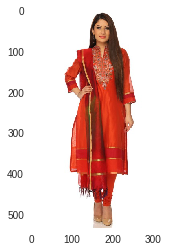

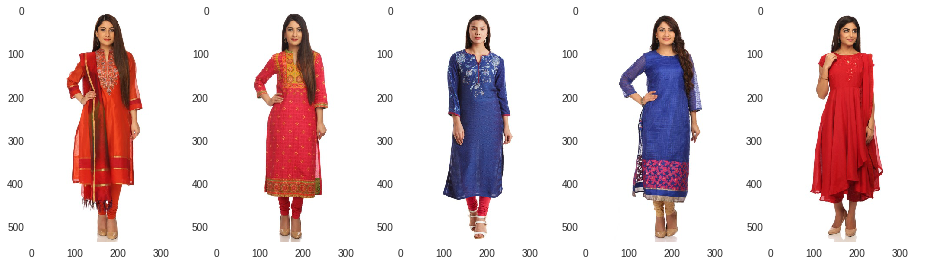

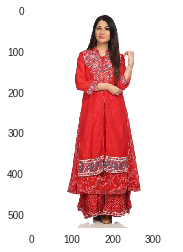

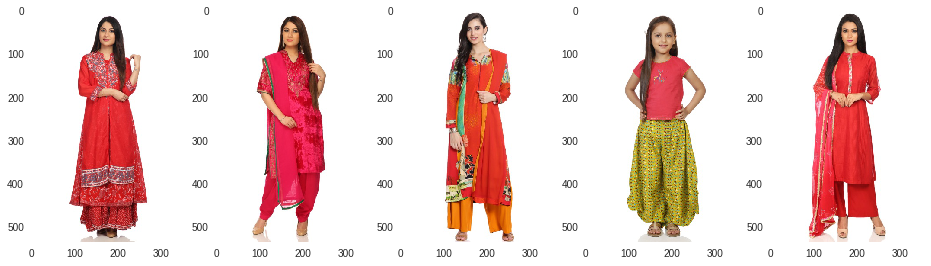

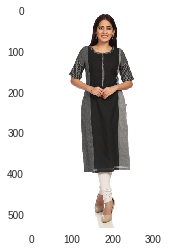

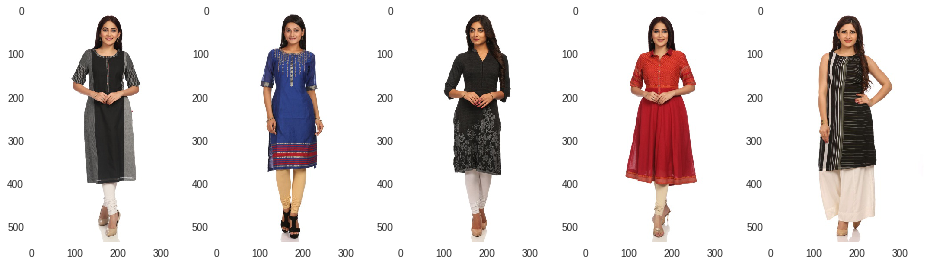

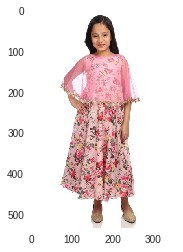

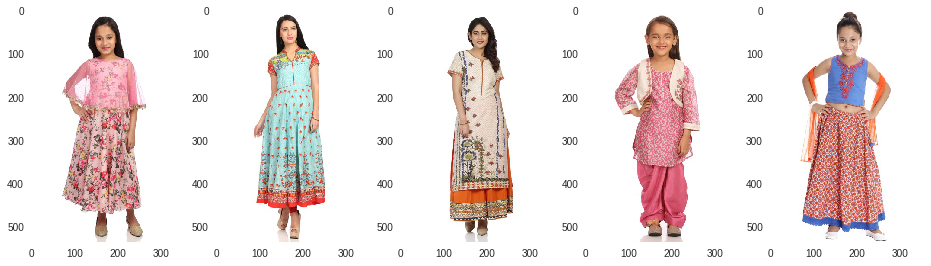

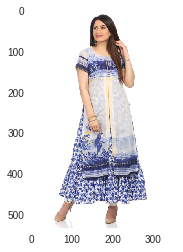

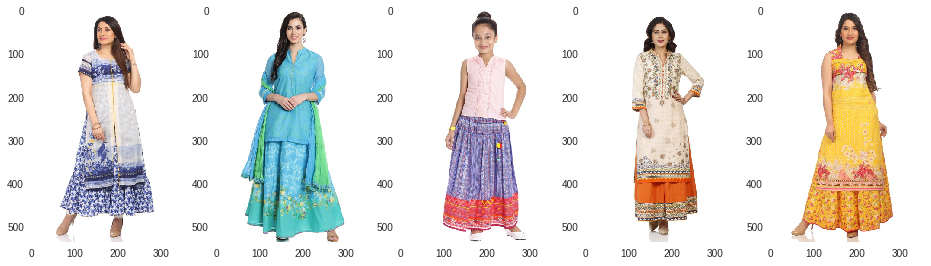

In [143]:
for i in range(5):
  file_name = random.choice(list(images_indices.keys()))
  get_prediction(file_name)

In [0]:
import tensorflow as tf
from tensorflow.keras import layers

In [0]:
def build_autoencoder():
  model = tf.keras.Sequential()
  # encoder
  model.add(layers.Input())
  model.add(layers.Conv2D())
  
  # decoder
  
  
  return model

In [0]:
p = """
embeddings {
  tensor_path: "feature_vecs_inception.tsv"
  sprite {
    image_path: "sprite.jpg"
    single_image_dim: 50
    single_image_dim: 50
  }
}
"""

c = """text_file = open("projector_config.pbtxt", "w");text_file.write(p);text_file.close()""" 

exec(c)

In [0]:
# !tensorboard --logdir .

In [0]:
# from google.colab import files
# files.download('feature_vecs.tsv') 

In [0]:
from google.colab import files
files.download('projector_config.pbtxt') 

In [0]:
# pip install tensorboardcolab

In [20]:
from tensorboardcolab import *

Using TensorFlow backend.


In [21]:
tbc=TensorBoardColab(graph_path=".")

Wait for 8 seconds...
TensorBoard link:
https://f9402126.ngrok.io
